*written by: Julia Knoblauch, Jana Vihs, Annika Boer, Kai Ingo Schewina*

# Explainable Recommendation Systems for Energy-Efficient Smart Home

<h2><center>Abstract</center></h2>

# Final documents:
- Assignment
- Explainability Agent:
- Performance Evaluation Agent:
- requirements.txt
- agents.py
- helper_functions.py
- (optional: adapt other agents)

# To do:


- Annika und Julia: Explainability Agent: outcome explainability des activity_agents & usage agents zusammenführen für recommendation
- Kai: Context Aware Related Literature, citation: manuell und references mit programm
- generell Zitieren über Google Scholar: APA
- LIME & SHAP für EBM unter model_type
- warnings aus Outputs rausschmeißen!!! (verbose=0?)

Weiteres:
- EDA: rausschmeißen & Text ergänzen
- formalisierung

## Table of contents - cleaned
1. Introduction
2. Literature Review
    
    2.1 Explainable AI:
    
    2.2 Recommender Systems in SH
    
    2.3 Explainability in RS

3. Methodology

    3.1 Recommender System

    3.2 Algorithms XAI
        - Taxonomy: Auswahl
        - Model-intrinsic: logit, knn, rf(?), gam
        - Model-agnostic
            Feature Importance: LIME, SHAP, plus evtl. CIU, DALEX, MAPLE
    
    3.3 Algorithms prediction:
    adaboost, xgboost

4. Experimental Design
    
    4.1 data organization
    
    4.2 Evaluation
        - Performance
        - Explainability

5. Results
   
    5.1 Performance
   
    5.2 Explainability
   
    5.3 Umbenennen: Decision for model & XAI model
   
    5.4 Final result of RS: Recommendation + Explanation

6. Discussion
    - Contributions
    - Limitations
    - Implications
    - Recommendations
    - Future Research

7. Conclusion

References

## Table of contents

1. Introduction:
    - RS & SH --> Energieeffizienz (wichtiges Problem, weil wir immer mehr Energie verbrauchen --> Quelle), Explainability Schlüssel!!! = Motivation
        - multi-agent RS bestehend aus Agents mit folgenden Aufgaben.. (nötig für 3, nicht wegnehmen von 4)
    - bisheriger Approach (Germain), unsere Erweiterung: Research Gap & Contribution
    - Struktur des Notebooks
2. Literature Review (Kai) --> Tabelle
    - Explainable AI (XAI)
        - Taxonomy: Annika
        - Criteria: Julia
    - Recommender Systems in SH: Fokus
    - Explainability in RS: Fokus
3. Methodology (i.e., the ML techniques that you apply)
    - Algorithms XAI
        - Taxonomy: Auswahl (Annika)
        - Model-intrinsic (Annika)
        - Model-agnostic (Machine Learning Interpretability: A Survey on Methods and Metrics)
            - LIME (Annika)
            - SHAP (Julia)
            - EBM (Jana)
        - vorgestellte Tabelle aus Präsi formaler --> Vergleich
    - Algorithms prediction (Jana, Formel für finales Modell, mit paper)
        xgboost, adaboost, knn, logit, rf, EBM --> warum erklärbar?

4. Experimental Design (including EDA, data organization, performance measures, etc.)
    - data organization (+ EDA von denen auf Wetterdaten + NAs Wetterdaten)
        - agents system (Bild) (Jana)
        --> Explainability Agent to be continued: erklären, was er macht (Julia, Annika)
        - restriction to 2 households
        - with & without weather data (Struktur, Herkunft, Nutzungsanweisung) (Kai)
    - Evaluation
        - Performance (Kai?)
        - Explainability (feature importance) (Julia)
5. Results
    - Performance (Kai?)
    - Explainability (Julia, Annika)
    - Final result of RS: Recommendation + Explanation (Jana): umbennenen: Decision for model & XAI model (Julia, Annika)
6. Discussion (Kai)
    - ...
    - Contributions
    - Limitations: making usage daily
    - Implications
    - Recommendations
    - Future Research: Neural Networks, mehrere recommendations pro Tag, GAMMLI (Jana)

e.g. include:
    - no user
    - runtime problems
        - api weather data 
        - 4 models, 20 households
        - Beispiel, wie lange es dauern würde, eine recommendation zu laden (aber nur 1x am Tag)

7. Conclusion: zusammenfassung in 2 abschnitten
References

In [ ]:
# Necessary packages to run notebook:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,5)

from IPython.display import Latex
from IPython.display import Image

from helper_functions import Helper
from agents import Performance_Evaluation_Agent
from agents import Preparation_Agent
from copy import deepcopy

helper = Helper()


In [ ]:
# Data
DATA_PATH = '../data/'

## 1. Introduction



Refer to MUlti Agent aus SEM IS

It consists of 6 different Agents which tackle different tasks. The acutal Recommendation Agent combines the output of the Usage Agent, the Load Agent and the Availability Agent which obtain there input data from the Preparation Agent. Further Information can be found in *ref*.


## 2. Literature Review

To navigate the space of explanation methods, we use the taxonomy of Singh et al. (2020).
This scheme presents one of many ways to classify different explainability methods.
Therefore, four questions are put to the reader.
First, it needs to be determined if the model can explain a particular model (model-specific) or many models (model-agnostic).
Then, the models are devided into local and global models, depending on if they can explain a particular sample or the entire model.
Additionally, the explanation can be made pre-model, in-model or post-model and last but not least, we distinguish between surrogate models, that work separately from the model and visualizations of the model.


https://christophm.github.io/interpretable-ml-book/
https://github.com/wangyongjie-ntu/Awesome-explainable-AI

### Explainable AI (XAI)
4 Richtungen der local approaches kurz zusammenfassen:
**Feature Importance (FI)**
**Rule Based (RB)**
**Prototypes (PR)**
**Counterfactuals (CF)**

-->+/- der appraoches nennen damit man in 3. erklären kann dass man FI nimmt und die Vorteile von RB
durch den Output als Liste.

### Criteria for XAI (Julia)

Robnik-Šikonja and Bohanec (2018) suggested properties of the explainers that differentiate the appraoches:
- Expressive Power: What logic does the explanation follow and which languge do they display?
- Translucency: Does the model decompose the predictive model (decomposition), treat the model as blackbox (pedagocial) or mix these approaches?
- Portability: Can the model be used on multiple predictive models i.e. is it model specific or agnostic?
- Algorithmic complexity: How time consuming are the computations?

Carvalho et. al (2019) propose additional properties that are useful in our situation:
- Stability: How stable are the explanations?
- Data Sampling: How is the data sampled e.g. for shapley value estimation?
- Shuffling/Permutation: How does the algorithms shuffle the data to derive the feature importance?

The explainability approaches will be evaluated on these critera in section 3.

Additionally, there are three options to evaluate the explainability approaches (Doshi-Valez & Kim, 2018).
Firstly, *Application grounded Evaluation* involves using humans in the real setting i.e. we need subjects that use our
recommender system in their smart home and evaluate the usefulness of the offered explanation. Secondly, another possibility
would be to use *Human-grounded Metrics* that would involve humans but not necessarily include the explainability
appraoch in a real task. In our case we could do experiments in which subjects have to choose between the explainability
approach e.g. based on their preference.
Thirdly, Doshi-Valez and Kim (2018) propose *Functionally-grounded Evaluation* that use proxies to evaluate the
explainability approach.
We will use the third approch as evaluations that involve the actual application of the recommender system are out of scope
for this seminar and the evaluation with humans and simplified tasks might not offer much external validity to the real setting.
*Could also be part of dicussion/ Future research to show different versions of our final output and what users like/disklike*

We will introduce the proxies for evaluation of the explanations in chapter 4.

### Recommender Systems in SH: Fokus
Recommender Systems tackle the energy efficiency problem through behavioral change [Einleitung?]. Have been applied a lot to other areas such as health, e-commerce, movies, but not that much to smart homes. Himeur et al. (2021) recently reviewed the existing approaches and deliver an exhaustive taxonomy, of which we will shortly present two aspects to classify our own system in the space of possibilities.

Regarding the objective of the recommender system, there exist two types, namely strategy recommenders, and action recommenders (Himeur et al. 2021). While the first type deals with long-term questions, such as the prediction of energy consumption in a building, the second tries to recommend actions to the occupants in order to optimize their behavior. Therefore, we apply an action recommender.

Secondly, there exist a multitude of methodologies and algorithms to achieve the task of energy efficiency by providing recommendations to users. The different options are displayed in Table X.

|     Methodology                                |     Description                                                                                                                   |     Example    |
|------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|----------------|
|     Case-based                                 |     Rule-based usage habits recommended to end-users                                                                              |                |
|     Collaborative filtering                    |     Closed set of actions, identify the preferred action                                                                          |                |
|     Context-aware                              |     Recommendations adjusted to circumstances of end-user, historical data as basis                                               |                |
|     Rasch-based                                |     Rasch analysis explores probability that end-user follows recommendation                                                      |                |
|     Probabilistic relational models   (PRM)    |     Captures users and transactions in a relational database and derives tailored recommendations                                 |                |
|     Fusion-based                               |     Different kinds of data help producing better predictions of habits, either by aggregating data or using   subrecommenders    |                |
|     Deep learning-based                        |     Utilize the ability of deep learning to detect patterns in the data                                                           |                |
|     Classical optimization                     |     Calculate optimal energy usage and provide insight to end-users and producers                                                 |                |

Our approach is part of the fusion-based recommender systems due to our inclusion of multiple data sources (i.e. historical user behavior, weather and energy price data). There is no article identified by Himeur et al. (2021) that combines this objective and methodology, and we therefore identify and address a research gap in this area. Jimenez-Bravo et al. (2019) applied a fusion-based approach to the energy efficiency problem in smart homes by combining electricity prices and household data. Their agent structure allows for similar behavior than our recommender system and therefore serves as an inspiration to our setup. Also, we both try to achieve our goal by suggesting to shift usages to more optimal timings. Contrarily, they address the strategy objective and do not allow for further data inclusion such as weather data.

Furthermore, we exhibit characteristics of the context-aware approach, as we include circumstances such as the availability of the user while calculating our recommendations.

Hier ergänzen?

#### Explainability in RS: Fokus
Himeur et al. (2021) provide an overview of current research gaps in the energy efficiency in smart home research area, in addition to their review of the state-of-the-art. We address one of the research gaps, i.e the explainability issue in recommender systems.

While Zhang & Chen (2018) provide an exhaustive review of the current literature on explainability in recommender systems, they do not limit themselves by the application environment (i.e. smart homes). Their classification scheme includes the form of explanation (e.g. textual, visual, hybrid …) and the explainable recommendation model (e.g. topic modeling, matrix factorization, post-hoc, …).

We utilize textual, post-hoc explanations, while simultaneously addressing the research gap identified by Zhang & Chen (2018) with regards to further aspects of explanation beyond persuasiveness (i.e. trustworthiness). Early research on trustworthiness is conducted by Cramer et al. (2008), that apply a system for artwork recommendations. Their results suggest a positive influence of explainability on the acceptance of the suggestions, while displaying the certainty of the system did not yield positive effects.

Sardianos et al. (2020) apply a context-aware recommendation system in a smart home ecosystem, that additionally delivers economical or ecological advantages, as well as explanations on the decision-making process. By conducting an experimental process, they conclude that only displaying the persuasive fact is not sufficient to achieve significant behavioral change. Contrarily, displaying the advantages, as well as the reasoning behind it, leads to a 19% increase in acceptance ratio.

Overall, there is very few work on explainability in recommender systems in the smart home ecosystem. We address current issues in this research area to increase trustworthiness and therefore behavioral change with regard to economical and ecological improvement.

## 3. Methodology

### 3.1 Recommender System

### 3.2 XAI Alogorithms
### (Taxonomy Auswahl?)

In this paper we will deal with both kinds of explainability methods, the model-intrinsic and the model-agnostic ones.
We will use the three model-intrinsic approaches logit, explainable boosting machines and random forest.
These models are already inherently interpretable.
Additionally, we use the model-agnostic approaches LIME and SHAP that are able to explain the prediction of any classifier.


### Model-Intrinsic Approaches

The lack of transparency and accountability in high stakes-decision making using black-box models can have severe consequences.
That led researchers concentrate on model-intrinsic explainability approaches which means that they are inherently explainable.


paper:
https://arxiv.org/pdf/1811.10154.pdf
https://arxiv.org/abs/2006.06466

Logit as benchmark?, GAMMLI, Random Forest (?)
### Model-Agnostic Approaches

Because of the wide use of black-box models in machine learning the need for model-agnostic approaches is immense.
The here used approaches LIME and SHAP are feature attribution methods.
This means they elaborate on which features are most influential in the black-box model's prediction.
These models do not have direct access to the internal model weights or structural parameters of the black-box model.

### LIME

One model-agnostic approach is LIME, developed by Ribeiro et al. (2016). LIME stands for "local, interpretable, model-agnostic explanation" and focuses on explaining the prediction of a single instance of data in an interpretable and faithful manner.
Explaining here means that it is made transparent to the user which characteristics have most influence in the black-box model's prediction.
The predictions produced by LIME are obtained by the minimization problem
$$\xi(x) = \underset{g~\in~G}{\operatorname{argmin}} \mathcal{L} (f, g, \pi_x) - \Omega (x) $$

where the input data point $x$ is one single instance with properties like the hour, a high temperature or the day name "Wednesday".
The optimization problem gets fed with the complex model $f$, that LIME tries to explain, and the simple model $g$ that comes from a family of interpretable models $G$, like e.g., linear regression.
The first loss term embodies the fidelity of the simple model approximating the complex model in the neighborhood of $x$.
In order to learn the local behavior of the complex model, the fidelity function \mathcal{L} is approximated by drawing samples, weighted by $\pi(x)$, that behaves like a proximity measure of the sampled data points to $x$.
The second loss term $\Omega(x)$ is used to regularize the complexity of the simple model $g$ like we know from LASSO or RIDGE regression for the linear model.

The following figure shall help for a better intuition of LIME. 
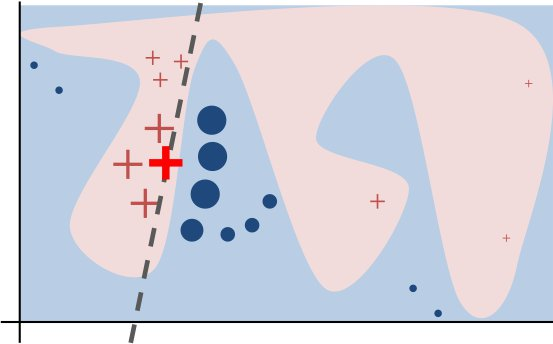
The blue and pink background shows the black-box model’s decision function $f$, that is unknown and nonlinear. Thus, it can not be well approximated by a linear model. The aim is to explain the bold red cross, a single instance's prediction of the black-box model. The LIME Algorithm then samples instances around the red cross by changing the feature values just a little bit. It then gets predictions using the complex model $f$.	The sampled instances then are weighted by the proximity to the bold red cross and the dashed line shows the learned explanation, that is locally faithful (but not globally).

The plot below shows the output of the LIME function. 

PLOT OF LIME FUNCTION HERE

It is a list of local explanations, reflecting the contribution of the features to the individual prediction of the black-box model. The output shown here is about the availability agent that predicts if a person is available to use a device at e.g., 9 o’clock on Monday. The predicted value is one, so the person is predicted to be at home and in this graph you can see which features have the most impact on the prediction. The orange bars show features pushing the prediction into the positive direction and the blue bars are pushing it in the negative direction. The hour 9 for example has positive influence but the day name "Wednesday" has negative influence. Overall the orange bars weight more and so the prediction is 1.

Characteristics of LIME: 
LIME can handle tabular, text and image data.



xgboost: resources to implement
https://github.com/marcotcr/lime/issues/334
https://github.com/adriamoya/xgboost_default_companies/blob/master/main.py
mention current approaches (no implementation as far as I know except SP-LIME for global)
https://arxiv.org/abs/2106.07875

Benchmarking and Survey of Explanation Methods for
Black Box Models - see chapter 4.1 for variants of LIME

https://arxiv.org/abs/2012.00093

### SHAP (Julia)
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume11%2Fstrumbelj10a%2Fstrumbelj10a.pdf&clen=690800&chunk=true
--> AnEfficient Explanation of Individual Classifications using Game Theory (2010)

Aktuell implementiert für KernelExplainer: vorher kmeans weil viel schneller
aber keine info zu tradeoff und keine wirklichen recommendations wie k= gesetzt werden sollte


### Other approaches to research:
https://www.linkedin.com/posts/hima-lakkaraju-b130217_himachilpptx-activity-6814735906092703744-fOYe/
https://interpretable-ml-class.github.io/
https://github.com/anguyen8/XAI-papers
https://towardsdatascience.com/the-how-of-explainable-ai-explainable-modelling-55c8c43d7bed
https://github.com/SeldonIO/alibi
https://github.com/pbiecek/xai_resources
https://github.com/interpretml/interpret

Don't put in eval but maybe mention:
**MUSE**
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fcs.stanford.edu%2Fpeople%2Fjure%2Fpubs%2Fexplanations-aies19.pdf&clen=1929781&chunk=true
"Faithful and Customizable Explanations of Black Box Models"
--> give concrete measures for xai other than fidelity
but: not open source package?

slides:
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Finterpretable-ml-class.github.io%2Fslides%2FLecture_11.pdf&clen=1064587&chunk=true

Don't put in eval but maybe mention:
**BETA**
https://arxiv.org/pdf/1707.01154.pdf
Interpretable & Explorable Approximations of Black Box Models
--> global approach, no package

from paper Bodria et. a. (2021):
see table 1 for overview on what else we could look at


Don't put in eval but maybe mention:
**py-ciu**
https://arxiv.org/abs/2006.00199
Explanations of Black-Box Model Predictionsby Contextual Importance and Utility
https://github.com/TimKam/py-ciu
--> also nice because working textual output
--> aber: kein prediction model daraus

**MAPLE**
-> check if they do surrogate model/ we would need to add to eval
https://github.com/GDPlumb/MAPLE
https://arxiv.org/abs/1807.02910
aber keine ahnung wie output ist & schlechte documentation

### 3.3 Prediction Algorithms


The following classical prediction algorihms were used:

**K-Nearest-Neighbour**: A classification algorithm (Cunningham et. al. 2020), where examples are classified based on the class of thir nearest neighbours.

**Logistic Regression**: A statistical model which usually refers to regression analyses for modeling the probability  of a certain class or event which in a binary problem which easily can be extended to model a multinomial class problem (Peng et. al. 2002).

**Random Forest**: A combination of tree predictors, where each tree depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest (Breiman, 2001).

**XGBoost** : A scalable end-to-end tree boosting system , which is used widley by data scientists to achieve state-of-the-art results (Chen et. al. 2016).

**AdaBoost**: A boosting algorithm which was first introduced by Freund and Schapire (1995), where one of the main ideas is to maintain a distribution or a set of weigths over the training set.

To include a global explainability approach we decided to include the following model.

**Explainable Boosting Maschine**: A glassbox model, which is a generalized additive model (GAM) of the form 
$$g(E[y]) = \beta_{0} + \sum f_{j}(x_{j}),$$ where $g$ denotes the link function which adapts the GAM to different application settings like classification or regression (H. Nori et. al. 2019). It is being highly intelligibile and explainable while being designed to have accuracy comparable to state-of-the-art machine learning models like Random Forest and Boostes Trees. Further, it is an additive model, which means that each feature contributes to predictions in a modular way. Hence, it is easy to reason about the contribution of each feature to the prediciton.

## 4. Experimental Design 


The following picture represents the Multi Agent with our modifications.
We developed an Explainability Agent, which... TO BE CONTINUED



In [ ]:
Image(filename='../pictures/structure.jpg')


### Data

The underlying data consist out of the REFIT Data which are Electrical Load Measurements provided by Murray et al. (2017). The data contains the energy consumption of nine different devices in Watts used in 20 households in the United Kingdom as well as the aggregate energy consumption in each household over the period 2013 to 2015. As the data only contains these energy consumption measured at eight-second intervals, we need to perform a few preparation steps including aggregating the data, cleaning the data, creating our target features and further feature creation. This task is tackled by the Prepapration Agent.
In order to improve our current Multi-Agent we extended our data set with specific weather features using the API from meteostat https://github.com/meteostat/meteostat-python.
The weather might be of cruical importance for the usage of some devices in a household. Hence we scraped the following additional features:

*dwpt* : The dew point in °C 

*rhum*: The relative humidity in perecent (%)

*temp* : The air temperature in °C

*wdir* : The average wind direction in degrees (°)

*wspd* : The avaerge wind speed in km/h

For some data points there existed missing values which where imputed by using teh K-Nearest-Neighbour Algorithm.


### Explorative Data Analysis





In [ ]:
# preparation of data 
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

shiftable_devices = ['Tumble Dryer', 'Washing Machine', 'Dishwasher'] # computer und tv sind m. E. non-shiftable, VR

device_params = {
    'threshold': 0.15
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params
}

# Load household and preprocess
household_id = 3
household = helper.load_household(DATA_PATH, household_id, weather_sel=True)
output, scaled, df = Preparation_Agent(household).pipeline_load(household, load_pipe_params)

The following correlation plot displays a positive correlation between the usage of the washing machine and the tumble dryer, which was expected, as if you use the washing machine and own a tumble dryer one would usually use it afterwards. Furthermore there seem to be strong positive correlation between the relative humidity (rhum) and the dew point (dwpt) and a strong negative correlation between the air temeprature (temp) and the dew point (dwpt).
n general, it can be said that the data are positively correlated with each other, but there are no strong interdependencies.


In [ ]:
plt.title('Correlation of weather features and Usage of Devices')
weather_df = df[['Tumble Dryer_usage', 'Washing Machine_usage', 'Dishwasher_usage','dwpt', 'rhum', 'temp', 'wdir', 'wspd']]
sns.heatmap(weather_df.corr(), annot=True)

Now we want to examine if a device was used multiple times each day. As for the tumble dryer there exist dates were it was used 8 times, the washing machine was used 9 times a day and the dishwasher was used 7 times a day as a max, which is rather rare but interesting for our recommendation system when it comes to saving energy and money.

In [ ]:
# Tumble Dryer in use
reIndexed = df.reset_index()
reIndexed['Date'], reIndexed['clock'] = reIndexed['Time'].apply(lambda x: x.date()), reIndexed['Time'].apply(lambda x: x.time())
wm = reIndexed['Washing Machine_usage']==1
td = reIndexed['Tumble Dryer_usage']==1
dw = reIndexed['Dishwasher_usage'] ==1
td_inuse = reIndexed[td]
td_inuse.groupby('Date')[['Tumble Dryer_usage']].count().describe()

In [ ]:
# Washing Machine in use
wm_inuse = reIndexed[wm]
wm_inuse.groupby('Date')[['Washing Machine_usage']].count().describe()

In [ ]:
# Dishwasher in use 
dw_inuse = reIndexed[dw]
dw_inuse.groupby('Date')[['Dishwasher_usage']].count().describe()

All devices show a mean around two, so on average each device is used two times a day.
As expected the following distplot shows a similiar distribution of the usage of the washing machine and the tumble dryer. 

In [ ]:
plt.title('Distribution of Tumble Dryer and Washing Machine Usage')
sns.distplot(td_inuse['Date'].value_counts().values)
sns.distplot(wm_inuse['Date'].value_counts().values)
plt.legend(labels=['Tumble Dryer', 'Washing Mashine'])

In [ ]:
plt.title('Distribution of Dishwasher Usage')
sns.distplot(dw_inuse['Date'].value_counts().values, color='green')

In [ ]:
# Look at dates of interest for Tumble dryer and Washing Machine
df_20_04_2014 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2014-04-20', axis=0)
df_10_08_2014 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2014-08-10', axis=0)
df_03_09_2015 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2015-09-03', axis=0)
df_26_06_2014 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2014-06-26', axis=0)
df_28_09_2013 = df[['dwpt','rhum','temp','wdir','wspd', 'Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2013-09-28', axis=0)

In [ ]:
# Look at dates of interest for Dishwasher
df_27_09_2013 = df[['dwpt','rhum','temp','wdir','wspd','Dishwasher_usage']].filter(like='2013-09-27', axis=0)
df_25_11_2014 = df[['dwpt','rhum','temp','wdir','wspd' ,'Dishwasher_usage']].filter(like='2014-11-25', axis=0)
df_19_10_2014 = df[['dwpt','rhum','temp','wdir','wspd', 'Dishwasher_usage']].filter(like='2014-10-19', axis=0)
df_01_07_2014 = df[['dwpt','rhum','temp','wdir','wspd', 'Dishwasher_usage']].filter(like='2014-07-01', axis=0)

In the following, we will examine the courses of the weather features and the use of the different household devices in order to detect any relations between those properties.
Especially those dates were each device is used multiple times are of great interest.
When it comes to the usage of the washing machine and tumble dryer, the course of the graphs confirms once again that the dryer is mostly used after the washing machine. Almost everytime those devices are used there seem to be a drop in the weather features, which indicates that those features would be helpful for our recommender system.

In [ ]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='TIme', ylabel='Value', dpi=100, axvspan=True):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, marker='o')
    plt.legend(df_27_09_2013.columns.tolist())
   
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_27_09_2013, x=df_27_09_2013.index, y=df_27_09_2013.values, title='Tumble Dryer and Waching Machine Usage on the 27.09.2013')  


On the days were each device was used multiple times like the 28.09.2013 or the 10.08.2014 were the tumble dryer was used 8 times a day it is important to note that it seemed to be running for 8 hours. In order to get a more precise insight into the user behavior at such special events, it would be useful to enrich our data with exact start and end times for each dryer cycle.

In [ ]:
plot_df(df_28_09_2013, x=df_28_09_2013.index, y=df_28_09_2013.values, title='Tumble Dryer and Washing Machine Usage on the 28.09.2013')

In [ ]:
plot_df(df_10_08_2014, x=df_10_08_2014.index, y=df_10_08_2014.values, title='Tumble Dryer and Washing Machine Usage on the 10.08.2014')

In [ ]:
plot_df(df_26_06_2014, x=df_26_06_2014.index, y=df_26_06_2014.values, title='Tumble Dryer and Washing Machine Usage on the 26.06.2014')

When it comes to the course of dishwasher use and weather data, no strong correlations can be found.

In [ ]:
plot_df(df_25_11_2014, x=df_25_11_2014.index, y=df_25_11_2014.values, title='Dishwasher Usage on the 25.11.2014')

In [ ]:
plot_df(df_19_10_2014, x=df_19_10_2014.index, y=df_19_10_2014.values, title='Dishwasher Usage on the 19.10.2014')

In [ ]:
plot_df(df_01_07_2014, x=df_01_07_2014.index, y=df_01_07_2014.values, title='Dishwasher Usage on the 01.07.2014')

In general, the relationship between the weather features and the usage of the devices of a household are worth investigating and will be further pursued when it comes to improving our Multi-Agent.

### Evaluation

#### Performance (Kai)

#### Explainability (Julia)

*altueller stand: in literature research properties of explainability models und hier konkrete metrics*

When is comes to our evaluation of the explainability approaches we want to quantitatively compare the
individual explanations that the models offer. The literature does no propose one clear framework
 which metrics to use as it is also highly application depenednt.
Nevertheless, we will use the following concepts that are widely applied to determine how well
 the explainability approaches work (Carvalho et. al, 2019):

**Accuracy** Similar to predictive accurary, the accuracy of the explanation method refers to how well the explainable model
predicts unseen instances compared to the real outcome. We will use the standard measure of accuracy, precicion and recall.
Note: accuracy might be misleading since imbalanced?

**Fidelity** This criteria determindes how close the prediction from the explainale model is to the black-box model.
Therefore, fidelity describes how well the explainability model is able to imitate the prediction of the black-box model.
We will again use the measure used for accuracy but replace the target label by the predictions from the black-box model.
Note that Carvalho et. al (2019) mention an interrelation between these two concepts: black-box models with high predictive
accuracy and explanations that offer a high fidelity are also highly accurate when it comes to the real predictions. This is
the ideal that we would like to achieve.

Additionally, we calculate the *Mean-Squared-Explainabilty Error* (MSEE) for every approach to measure not only if
the decicion of the black-box model and the explainability approach is the same but also to measure how close they are to each other.
This metrics represents how well the explainability approaches are calibrated. The formula of the traditionally used
Mean-Squared-Error is adapted in the following way: *citation missing*

$$ MSEE_{} = \frac{1}{n} (y_{pred} - y_{expl})^2 $$


**Interpretability/ Comprehensibility/ Understandability** This critera deals with how well humans actually
 understand the explanations. Since we have decided on functionally-grounded evaluations
we have to rely on proxies like ...
*hm entweder vlt das erst danach vergleichen z.b. fidelity für verschiedene anzahl and features?
oder: ??
oder: nicht vergleichen und sagen dass wir dadurch dass wir
alles am ende auf den selben output bringen, dass das nicht nötig ist?*
--> hier noch citation wenn was gefunden was wir machen könnten: am coolsten wäre ein plot iwie

**Efficiency** Lastly, we will evaluate how efficient the explainability appraoches are in calculating
the local explanations. To the end we will measure the time that each method needs to calculate all the
local explanations for a day and average the values.

Zur Info:
--> Precicion (What proportion of positive identifications was actually correct?)
--> Recall (What proportion of actual positives was identified correctly?)

## Results

### Performance

### Explainability

### Umbenennen: Decision for model & XAI model

## **1. Load and Pre-process Data**

### **1.1 Initialize and load python scripts**

In [1]:
# loading necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os

from helper_functions import Helper
from agents import Preparation_Agent
from datetime import datetime

helper = Helper()

In [2]:
DATA_PATH = '../data/'

### **1.2 Set Params**

**Note:** For the full detail of the parameters and the preprocessing agents take a look at the Preparation Agent's notebook.

In [3]:
# load household data for Household 1
household = helper.load_household(DATA_PATH, 3)

In [4]:
threshold = 0.01
active_appliances = ['Toaster', 'Tumble Dryer', 'Dishwasher', 'Washing Machine','Television', 'Microwave', 'Kettle']
shiftable_devices = ['Tumble Dryer', 'Washing Machine', 'Dishwasher']


In [5]:
#activity params
truncation_params = {
    'features': 'all',
    'factor': 1.5,
    'verbose': 0
}

scale_params = {
    'features': 'all',
    'kind': 'MinMax',
    'verbose': 0
}

aggregate_params = {
    'resample_param': '60T'
}

activity_params = {
    'active_appliances': active_appliances,
    'threshold': threshold
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

#load agent
device_params = {
    'threshold': threshold
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices,
    'device': device_params
}

#usage agent

device = {
    'threshold' : threshold}

aggregate_params24_H = {
    'resample_param': '24H'
}

usage_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'activity': activity_params,
    'aggregate_hour': aggregate_params,
    'aggregate_day': aggregate_params24_H,
    'time': time_params,
    'activity_lag': activity_lag_params,
    'shiftable_devices' : shiftable_devices,
    'device': device
}

In [6]:
# calling the preparation pipeline
#prep = Preparation_Agent(household)
#activity_df = prep.pipeline_activity(household, activity_pipe_params)
#load_df, _, _ = prep.pipeline_load(household, load_pipe_params)
#usage_df = prep.pipeline_usage(household, usage_pipe_params)

#load price data
#FILE_PATH = '/content/drive/MyDrive/T4_Recommendation-system-for-demand-response-and-load-shifting/02_data/'
#price_df = helper.create_day_ahead_prices_df(DATA_PATH, 'Day-ahead Prices_201501010000-201601010000.csv')


In [7]:
#activity_df.to_pickle('../data/processed_pickle/activity_df.pkl')
#load_df,_, _ .to_pickle('../data/processed_pickle/load_df.pkl')
#usage_df.to_pickle('../data/processed_pickle/usage_df.pkl')
#price_df.to_pickle('../data/processed_pickle/price_df.pkl')

In [6]:
# Load pickle data
activity_df = pd.read_pickle('../data/processed_pickle/activity_df.pkl')
load_df = pd.read_pickle('../data/processed_pickle/load_df.pkl')
usage_df = pd.read_pickle('../data/processed_pickle/usage_df.pkl')
price_df = pd.read_pickle('../data/processed_pickle/price_df.pkl')

In [7]:
from agents import Activity_Agent, Usage_Agent, Load_Agent, Price_Agent, Recommendation_Agent, Explainability_Agent

In [8]:
recommend = Recommendation_Agent(activity_df, usage_df, load_df, price_df, shiftable_devices, model_type = "logit")
price = recommend.electricity_prices_from_start_time("2014-08-21")
recommend.cost_by_starting_time("2014-02-20", "Washing Machine")

array([ 7714.454691  ,  7678.84914736,  7557.7928611 ,  7514.76268745,
        7989.24318101,  9053.34757816,  9897.56262352, 10073.83654995,
       11124.84860431, 12061.26123895, 11369.48796488, 10678.23619665,
        9548.29185135,  9048.27794987,  9112.4028526 ,  9698.53624983,
       11241.48330604, 13900.90208428, 13916.73933837, 10107.80814897,
        9228.11999008,  8719.83762906,  8475.29681857,  8550.31955076])

In [9]:
recommendation_by_decvice_dict = recommend.recommend_by_device("2014-08-21", "Dishwasher", 0.3, 0.3, evaluation=False, model_type = "logit", weather_sel = True)

inside of evaluation
logit


In [10]:
recommendation_by_decvice_dict

{'recommendation_date': ['2014-08-21'],
 'device': ['Dishwasher'],
 'best_launch_hour': [12],
 'no_recommend_flag_activity': [0],
 'no_recommend_flag_usage': [0],
 'recommendation': [12],
 'sentence_dummy': [              col_name  feature_importance_vals
  2      activity_lag_48                 0.118827
  1      activity_lag_24                 0.116599
  3      activity_lag_72                 0.049639
  7    day_name_Thursday                 0.046691
  12                temp                 0.033523
  10                dwpt                 0.014418
  14                wspd                 0.006061
  0                 hour                 0.005229
  11                rhum                 0.001678
  13                wdir                 0.000366
  4      day_name_Monday                 0.000000
  5    day_name_Saturday                 0.000000
  6      day_name_Sunday                 0.000000
  8     day_name_Tuesday                 0.000000
  9   day_name_Wednesday                 0.0

### Final result of RS: Recommendation + Explanation
Note:  Carvalho et. al (2019) mention criteria for Human-friendly explanations that we could include here for reasoning
our final explanation approach


## 6. Discussion 

### Contributions


### Limitations 


So many different approaches. Available Github Repos but dependencies cause several conflicts due to different package versions.
Missing user data. To evaluate the explainability approach from a human perspektive ot would be of cruical importance to measure users trust and acceptance 

### Implications

### Future Research

Gammli- Generalized Additive Modeling with Manifest and Latent Interactions, several recommendations per day.

paper: 'Human-in-the-Loop Interpretability Prior'
paper: https://dl.acm.org/doi/abs/10.1145/3351095.3375624

## 7. Conclusion

## References

1. InterpretML: A Unified Framework for Machine Learning Interpretability (H. Nori, S. Jenkins, P. Koch, and R. Caruana 2019)

2. Cunningham, Padraig & Delany, Sarah. (2020). k-Nearest Neighbour Classifiers -- 2nd Edition. 

3. Tianqi Chen and Carlos Guestrin. XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, KDD ’16, pages 785–794, New York, NY, USA, 2016. ACM. ISBN 978-1-4503- 4232-2. doi: 10.1145/2939672.2939785. URL http://doi.acm.org/10.1145/2939672. 2939785.

4. Breiman, Leo. (2001). Machine Learning, Volume 45, Number 1 - SpringerLink. Machine Learning. 45. 5-32. 10.1023/A:1010933404324. 

5. Yoav Freund and Robert E. Schapire. A decision-theoretic generalization of on-line learning
and an application to boosting. Journal of Computer and System Sciences, 55(1):119–139,
August 1997.

6. Chen, Tianqi & Guestrin, Carlos. (2016). XGBoost: A Scalable Tree Boosting System. 785-794. 10.1145/2939672.2939785. 

7. Peng, Joanne & Lee, Kuk & Ingersoll, Gary. (2002). An Introduction to Logistic Regression Analysis and Reporting. Journal of Educational Research - J EDUC RES. 96. 3-14. 10.1080/00220670209598786. 

8. Singh, Sengupta, Lakshminarayanan. (2020). Explainable Deep Learning Models in Medical Image Analysis. Journal of Imaging 6, 52.

9. Ribeiro, Singh, Guestrin. (2016). "Why should I trust you?" Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 1135–1144.